In [1]:
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.signals.common import Waveform





from sigvisa.source.event import get_event






from sigvisa.infer.run_mcmc import run_open_world_MH

from sigvisa.infer.mcmc_logger import MCMCLogger

In [2]:
"""
sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",
                      wiggle_model_type="dummy", wiggle_family="dummy",
                      phases="leb", nm_type = "ar")
evid = 5335822
wave = Waveform(data=np.zeros(20), stime=1240241314.33, srate=5.0, sta="MKAR", chan="BHZ", filter_str="freq_0.8_4.5")
wn = sg.add_wave(wave)
ev = get_event(evid=evid)
evnodes = sg.add_event(ev, observed=True)"""
"""logger = MCMCLogger(write_template_vals=True, dump_interval=100)
run_open_world_MH(sg, steps=5000,
                  enable_template_moves=True,
                  enable_event_moves=True,
                  logger=logger,
                  enable_event_openworld=False,
                  enable_template_openworld=False)"""
"""def build_relocation_sg_leb(evids, stas):
    sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",
                      wiggle_model_type="dummy", wiggle_family="dummy",
                      phases="leb", nm_type = "ar")
    
    for evid in evids:
        for sta in stas:
            wave = load_event_station_chan(evid, sta, "auto", exclude_other_evs=True)
            sg.add_wave(wave)
    for evid in evids:
        ev = get_event(evid)
        sg.add_event(ev, observe=True)
    return sg

    sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",
                      wiggle_model_type="dummy", wiggle_family="dummy",
                      phases="leb", nm_type = "ar")"""

'def build_relocation_sg_leb(evids, stas):\n    sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",\n                      wiggle_model_type="dummy", wiggle_family="dummy",\n                      phases="leb", nm_type = "ar")\n    \n    for evid in evids:\n        for sta in stas:\n            wave = load_event_station_chan(evid, sta, "auto", exclude_other_evs=True)\n            sg.add_wave(wave)\n    for evid in evids:\n        ev = get_event(evid)\n        sg.add_event(ev, observe=True)\n    return sg\n\n    sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",\n                      wiggle_model_type="dummy", wiggle_family="dummy",\n                      phases="leb", nm_type = "ar")'

In [3]:

from sigvisa.synthetic.doublets import *

def sample_events(basedir, seed=40):
    n_evs = 1
    lons = [129, 130]
    lats = [-3.5, -4.5]
    times = [1238889600, 1245456000]
    mbs = [4.0, 5.0]
    sw = SampledWorld(seed=seed)
    sw.sample_region_with_doublet(n_evs, lons, lats, times, mbs, doublet_idx=0, doublet_dist=0.01)
    sw.stas = ["FITZ",]
    gpcov = GPCov([0.7,], [ 40.0, 5.0],
                  dfn_str="lld",
                  wfn_str="compact2")
    param_means = build_param_means(sw.stas)
    sw.set_basis(wavelet_family="db4_2.0_3_30", iid_repeatable_var=0.1,
                  iid_nonrepeatable_var=0.4, srate=5.0)
    sw.joint_sample_arrival_params(gpcov, param_means)
    sw.sample_signals("freq_0.8_4.5")

    wave_dir = os.path.join(basedir, "sampled_%d_simple" % seed)
    sw.serialize(wave_dir)
    #sw.train_gp_models_true_data()
    #sw.save_gps(wave_dir, run_name="synth_truedata")
    return sw


import os
basedir = os.path.join(os.getenv("SIGVISA_HOME"), "experiments", "synth_wavematch")
sw = sample_events(basedir)

wave_dir = os.path.join(basedir, "sampled_%d_spreadtime" % 0)
#sw = load_sampled_world(wave_dir)


sampled true coefs at FITZ
sampling w/ seed 1751002438
sampling w/ seed 618510555


In [4]:
print sw.tm_params


{'FITZ': {'tt_residual': array([-0.61233054, -0.13297566]), 'coda_decay': array([-4.64968244, -4.64540688]), 'peak_decay': array([-0.9495343 , -0.99458042]), 'amp_transfer': array([ 3.63528211,  4.01327008]), 'peak_offset': array([ 0.04836445,  0.15413252])}}


evid None, loc 129.41 E 3.56 S, depth 0.0km, time 1244067435.4, mb 4.3, natural source
evid None, loc 129.41 E 3.56 S, depth 0.0km, time 1242985800.5, mb 4.5, natural source
-0.61510725469 -0.3753705197


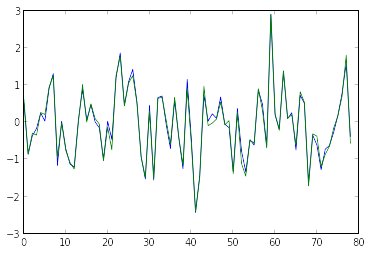

In [5]:
print sw.evs[0]
print sw.ev_doublet

plot( sw.true_coefs['FITZ'][0,:])
plot( sw.true_coefs['FITZ'][1,:])
print sw.true_coefs['FITZ'][0][70], sw.true_coefs['FITZ'][1][70]

[ 3.26180098  2.38190205  2.91308078  3.14856264  2.55032506  3.28554206
  3.7875682   3.40228995  2.70952153  3.10810174]


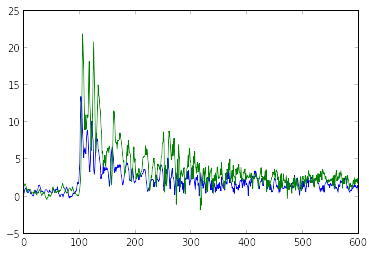

In [6]:

plot( sw.waves[0]['FITZ'].data[400:1000])
plot( sw.waves[1]['FITZ'].data[400:1000])

print sw.waves[1]['FITZ'].data[600:610]

In [7]:
import copy

def corrupt_ev(ev, stddevs):
    ev = copy.copy(ev)
    ev.lon = ev.lon + np.random.randn() * stddevs['lon']
    ev.lat = ev.lat + np.random.randn() * stddevs['lat']
    ev.depth = ev.depth + np.random.randn() * stddevs['depth']
    ev.time = ev.time + np.random.randn() * stddevs['time']
    ev.mb = ev.mb + np.random.randn() * stddevs['mb']
    return ev

def set_true_templates(sg, sw, include_doublet=False):
    for sta in sw.tm_params.keys():
        for i in range(len(sw.evs) + (1 if include_doublet else 0)):
            tmnodes = sg.get_template_nodes(eid=i+1, sta=sta, phase=sw.phase, chan=sw.chans[sta], band=sw.band)
            for param in sw.tm_params[sta]:
                k, n = tmnodes[param]
                n.set_value(sw.tm_params[sta][param][i])

sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",
                  wiggle_model_type="gp_joint", wiggle_family="db4_2.0_3_30",
                  phases=["P",], nm_type = "ar", runids=(-1,), joint_wiggle_prior=(0.01, sw.gpcov))

for i in sw.waves.keys():
    for sta in sw.waves[i].keys():
        wn = sg.add_wave(sw.waves[i][sta])
        basis, iid_std, target_coef = wn.wavelet_basis
        wn.wavelet_basis = (basis, sw.scaled, target_coef)
        
stddevs = {"lon": 0.2, "lat": 0.2, "depth": 20.0, "time": 3.0, "mb": 0.3}

sg.add_event(sw.evs[0], observed=sw.evs[0], stddevs=stddevs, fixed=True)
sg.add_event(sw.ev_doublet, observed=sw.ev_doublet, stddevs=stddevs, fixed=False)
    
set_true_templates(sg, sw, include_doublet=True)

In [8]:
wn1 = sg.station_waves['FITZ'][0]
wn2 = sg.station_waves['FITZ'][1]

wn1._parent_values()
wn1.pass_jointgp_messages()
wn2._parent_values()
wn2.pass_jointgp_messages()

print [(c[0], c[1], c[3], c[4]) for c in wn1.tssm_components]

[(None, None, 0, 2000), (1, 'P', 496, 444), (1, 'P', 496, 1500), (1, 'P', 496, 2309)]


[ 0.84261498  0.84261473  0.84261395  0.84215835  0.84253855  0.7658986
  0.84036609  0.32161946  0.84261335  0.84009528  0.81936706  0.31996012
  0.71147514  0.24043485  0.84251957  0.81490213  0.36405155  0.38053481
  0.21110014  0.40778782  0.19153079  0.24237744  0.13775134  0.14796809
  0.32338528  0.43697095  0.27298996  0.15925496  0.16967763  0.30072425
  0.1794771   0.18882375  0.39899286  0.51742654  0.3264102   0.19782867
  0.20656876  0.35059544  0.2150996   0.22346263  0.45993255  0.57091201
  0.37366984  0.23168951  0.23980493  0.40882821  0.24782839  0.25577547
  0.5180886   0.60110841  0.48333807  0.26365879  0.27151942  0.51125697
  0.28796178  0.39515702  0.59100835  0.62722198  0.52545988  0.43026554
  0.43714974  0.53843091  0.44136176  0.44552506  0.62104595  0.65141488
  0.55110967  0.44974596  0.45402307  0.56309222  0.45835478  0.46273929
  0.64771413  0.67362195  0.57483643  0.46717295  0.4715674   0.58589112
  0.47407467]


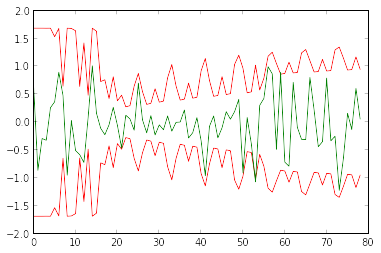

In [9]:
ell, prior_means, prior_vars, posterior_means, posterior_vars = wn1._coef_message_cache

#plot(posterior_means, c='blue')
print np.sqrt(posterior_vars)
plot( 2*np.sqrt(posterior_vars), c='red')
plot(-2*np.sqrt(posterior_vars), c='red')

plot(sw.true_coefs['FITZ'][1] - posterior_means, c='green')

In [10]:
logger = MCMCLogger(write_template_vals=False, dump_interval=5)

corrupted_evs = []
for i,ev in enumerate(sw.evs):
    eid = i+1
    lon = sg.all_nodes["%d;lon_obs" %eid ].get_value()
    lat = sg.all_nodes["%d;lat_obs" %eid ].get_value()
    depth = sg.all_nodes["%d;depth_obs" %eid ].get_value()
    mb = sg.all_nodes["%d;mb_obs" %eid ].get_value()
    time = sg.all_nodes["%d;time_obs" %eid ].get_value()
    cev = Event(lon=lon, lat=lat, depth=depth, mb=mb, time=time, eid=eid)
    corrupted_evs.append(cev)
    
with open(os.path.join(logger.run_dir, "obs_events.pkl"), "wb") as f:
    pickle.dump(corrupted_evs, f)

with open(os.path.join(logger.run_dir, "events.pkl"), "wb") as f:
    pickle.dump(sw.evs, f)
    
#%debug
print sg.current_log_p(verbose=True)
print "hello"
run_open_world_MH(sg, steps=1000,
                  enable_template_moves=True,
                  enable_event_moves=True,
                  logger=logger,
                  enable_event_openworld=False,
                  enable_template_openworld=False)

node 1;loc has logp -9.2
node 1;lon_obs has logp 0.7
node 1;lat_obs has logp 0.7
node 2;loc has logp -9.2
node 2;mb has logp -4.8
node 2;P;FITZ;:;:;tt_residual has logp -0.9
node 2;time has logp 0.0
node 2;P;FITZ;BHZ;freq_0.8_4.5;peak_offset has logp -1.1
node 2;source has logp -0.0
node 2;P;FITZ;:;:;amp_transfer has logp -3.6
node 2;P;FITZ;BHZ;freq_0.8_4.5;peak_decay has logp -1.4
node 2;P;FITZ;BHZ;freq_0.8_4.5;coda_decay has logp -11.7
FITZ -715.214680326 -161.624081475 -553.59059885
node wave_FITZ_BHZ_freq_0.8_4.5_1242985913.6 has logp -553.6
node 1;time has logp 0.0
node 1;time_obs has logp -2.0
node 2;lon_obs has logp 0.7
node 1;depth_obs has logp -3.9
node 1;mb has logp -4.4
node 1;P;FITZ;BHZ;freq_0.8_4.5;coda_decay has logp -11.7
node 1;P;FITZ;BHZ;freq_0.8_4.5;peak_decay has logp -1.4
node 1;P;FITZ;:;:;amp_transfer has logp -3.3
node 1;source has logp -0.0
node 1;P;FITZ;BHZ;freq_0.8_4.5;peak_offset has logp -1.1
node 1;P;FITZ;:;:;tt_residual has logp -1.1
FITZ -342.714309379 -16

In [11]:
sg.current_log_p_breakdown()

n_uatemplate: -0.8
n_event: -1385.7
ev priors: ev -27.9
ev observations: ev -8.7
tt_residual: ev -2.8
ev global cost (n + priors + tt): -1416.3
coda_decay: ev -25.3 ua 0.0 total -25.3
peak_decay: ev -2.6 ua 0.0 total -2.6
peak_offset: ev -2.3 ua 0.0 total -2.3
coda_height: ev -6.9 ua 0.0 total -6.9
coef jointgp: -274.5
total param: ev -311.6 ua 0.0 total -311.6
priors+params: ev -1736.6 ua -0.8 total -1737.4
station noise (observed signals): -738.3
overall: -2475.7
official: -2475.7


In [12]:
print sg.get_event(1)
print sg.get_event(2)

evid None, loc 129.41 E 3.56 S, depth 0.0km, time 1244067435.4, mb 4.3, natural source
evid None, loc 129.40 E 3.55 S, depth 0.0km, time 1242985799.2, mb 4.5, natural source
